# Initial Observations and Approach

Initially, looking at the image data and labels highlights a few key points which could simplify the problem. They are:
1. We don't need the exact positions of shapes. Hence it is better to eliminate any bounding box based approaches which need label augmentation and annotation. It would be sub-optimal even if it made color detection very easy.
2. The entire model pipeline has to learn a) to recognise various shapes b) recognise the color of a _respective_ shape.
3. The shapes do not overlap. Hence, we could get discrete shape boundaries by preprocessing, such as binarizing and edge detection. Since arrangement of boundaries are mainly what distinguish various shapes, and not their bulk volume, we can save processing this way.
4. For learning to recognise shapes, we can try classification and regression approaches. For classification, we'll have binary labels indicating presence or absence of particular shape in image. For regression, we can have counts of each shape, if present. Need to test each approach. As a prior, I believe regression is a better approach since the model can learn to recognise shapes at various scales and orientations, which is crucial for this task.
5. Since we're looking for spatial arrangement recognition, a CNN would be ideal. Can run experiments on model structure, hyperparameters, data augmentation and train-time methods such as learning rate scheduling for this. Need to monitor train and validation loss to look out for overfitting.

Let's look at the data and draw some conclusions:

## 1. Loading up necessary libraries and viewing data

#### Installing necessary dependencies


In [ ]:
!pip install cv2
!pip install torch
!pip install ast
!pip install time
!pip install collections
!pip install torch
!pip install PIL
!pip install numpy 
!pip install os
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

In [403]:
import cv2
import torch
import ast
import time
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

cuda


In [3]:
#Creating a custom PyTorch dataset for the training data
class ImageDataset(Dataset):
    def __init__(self,csv_data,transform):
        self.data = pd.read_csv(csv_data)
        self.transforms = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        img_path = 'dataset/' + self.data.iloc[idx,0]
        label = self.data.iloc[idx,1]
        image = Image.open(img_path)
        image = self.transforms(image)
        return image, label

In [4]:
transform1 = transforms.Compose([transforms.ToTensor()]) #Converting PIL to tensor
sample_dataset = ImageDataset(csv_data='train.csv',transform=transform1)
sample_loader = DataLoader(sample_dataset,batch_size=16,shuffle=False)

In [5]:
#Pull first batch and view it
train_batch = next(iter(sample_loader))

##### Checking RGB allocation

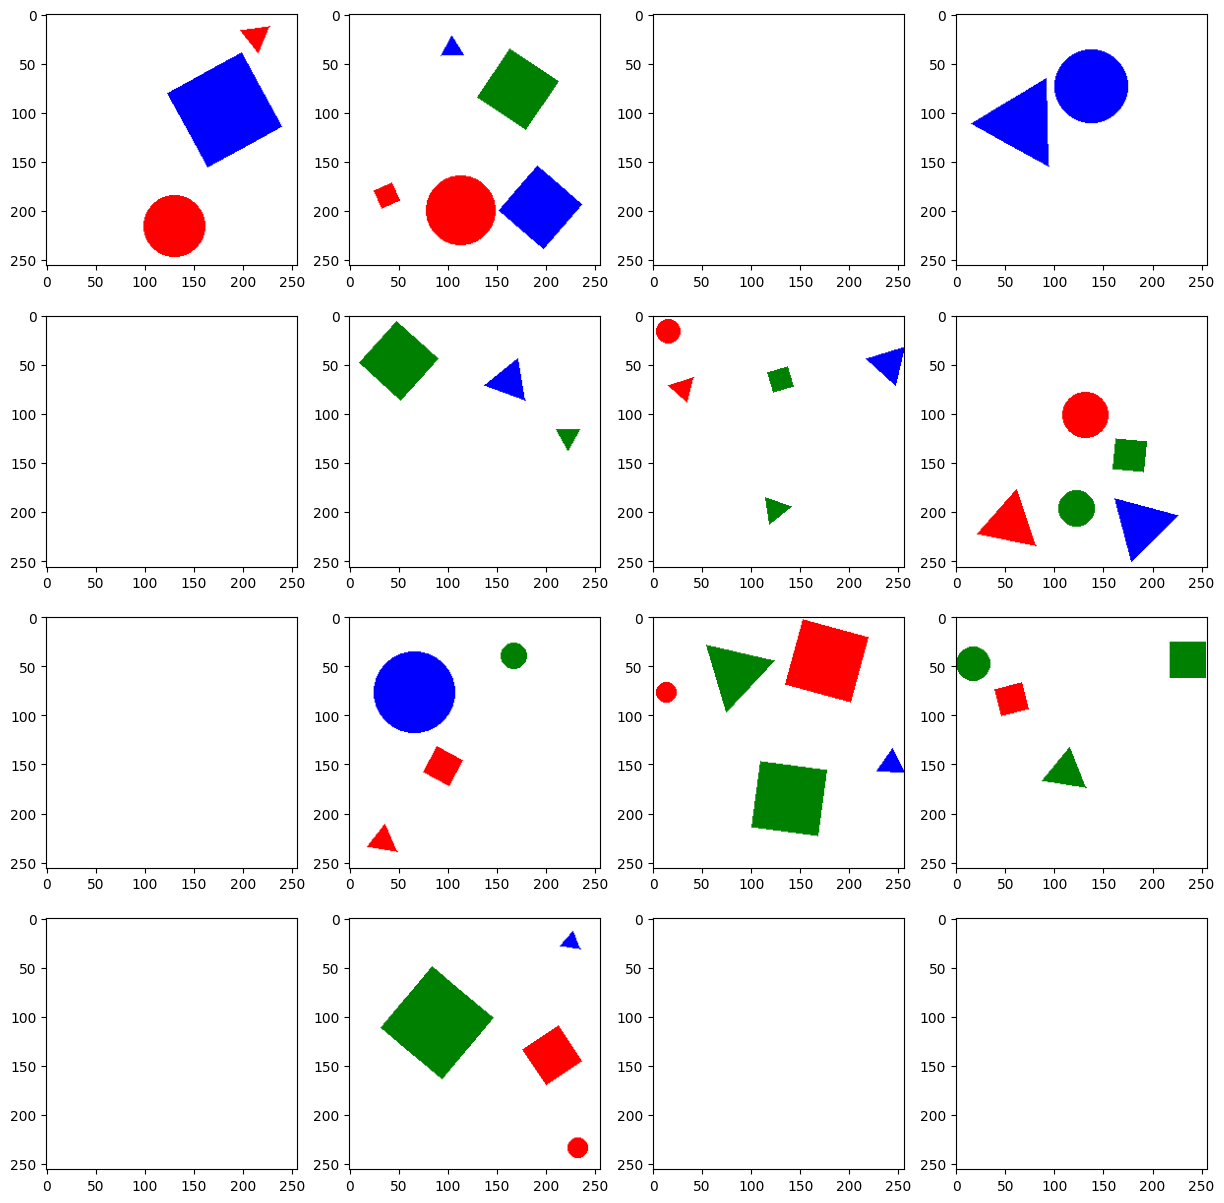

In [6]:
fig, axs = plt.subplots(4,4,figsize = (15,15))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow((train_batch[0][i*4+j, :, :]).permute(1,2,0))
        #axs[i,j].set_title(train_batch[1][i*4+j])
        axs[i, j].axis('on')

#We've plotted row-wise beginning from image_0.png. Let us quickly check if our RGB allocation corresponds to the ground truth labels or not.
#We also know that the images are properly arranged sequentially, since we didn't add shuffle=True while loading the batch

In [7]:
t_csv = pd.read_csv("train.csv")
print(t_csv.iloc[6].values)

['train_dataset/img_6.png'
 "[('triangle', 'green'), ('square', 'green'), ('circle', 'red'), ('triangle', 'blue'), ('triangle', 'red')]"]


##### So yes, we've loaded them correctly.

### Observations

The images have a white background. All of the shapes are coloured respectively and don't overlap. Our output does not require the positions of images. Our output is not ordered in any particular way, i.e no ordering of shapes or colours. Our model has to learn:
1. To recognise various shapes and differentiate between them despite being differently scaled and oriented.
2. To classify colours of the shapes.

Taking advantage of the fact that these images have very sharp colour gradients differentiating them from the background, let's use a Canny Edge detector to get sharp masks of the shapes. We can then train our shape recognition models on these images to make it easier for model to understand. 
In this first part, we train models just to recognise shapes. The colour information will be split apart and used in the second part of training. 

# 2. Preprocessing 

In [8]:
transform2 = transforms.Compose([
    transforms.Lambda(lambda x: cv2.cvtColor(np.array(x), cv2.COLOR_RGB2BGR)),
    transforms.Lambda(lambda x: cv2.Canny(x, 5, 70)), 
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),
    transforms.Normalize(0,1)
])

In [9]:
transformed_dataset = ImageDataset(csv_data='train.csv',transform=transform2)
transformed_loader = DataLoader(transformed_dataset,batch_size=16,shuffle=False)

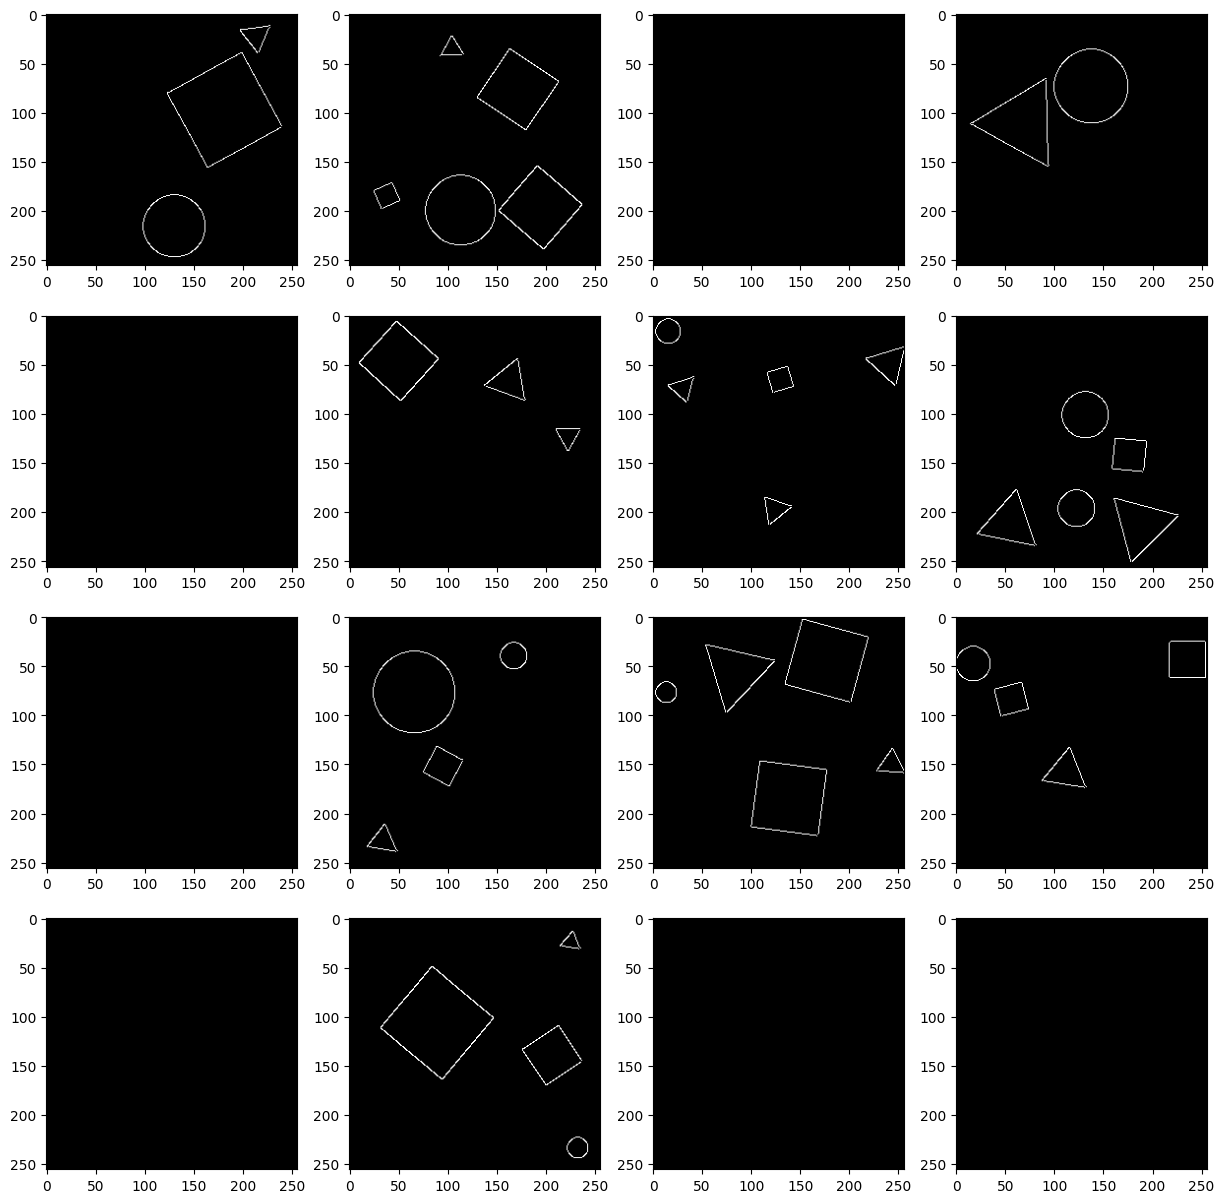

In [10]:
trans_batch = next(iter(transformed_loader))
fig, axs = plt.subplots(4,4,figsize = (15,15))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow((trans_batch[0][i*4+j, :, :].permute(1,2,0)),cmap='gray')
        axs[i, j].axis('on')

Ideally, we would like to map these shapes to the shape type, i.e triangle, rectangle or circle. Let's run a CNN model to map from these masks to the presence of individual shapes and also the counts of each shape. To do this, let's create some different labels, which will be a tensor derived from the presence of triangles, rectangles and squares in the input labels.  

### Preparing training data for the model

We create two classes for training, `ClassData` for classification and `RegData` for regression. The classes will be used to create instances of training and test data as per our need.

In [344]:
class ClassData(Dataset):
        def __init__(self,csv_data,transform):
            self.data = pd.read_csv(csv_data)
            self.transforms = transform
            self.classes = list(set(shape for sublist in self.data['label'] for (shape, _) in ast.literal_eval(sublist))) #Find unique shapes in label of dataFrame
        
        def __len__(self):
            return len(self.data)
    
        def __getitem__(self,idx):
            img_path = 'dataset/' + self.data.iloc[idx,0]
            label = self.data.iloc[idx,1] #Is a string of list of tuples
            shapes = ast.literal_eval(label) #Converts string to list
            shape_counts = Counter(shape for shape, color in shapes) #Counts only shapes in label

            label_tensor = torch.tensor([shape_counts.get(shape,0) for shape in self.classes], dtype = torch.float32)
            for i in range(len(label_tensor)):
                if label_tensor[i] > 0:
                    label_tensor[i] = 1
                else: 
                    continue
            image = Image.open(img_path)
            image = self.transforms(image)
            return image, label_tensor

In [12]:
class RegData(Dataset):
        def __init__(self,csv_data,transform):
            self.data = pd.read_csv(csv_data)
            self.transforms = transform
            self.classes = list(set(shape for sublist in self.data['label'] for (shape, _) in ast.literal_eval(sublist))) #Find unique shapes in label of dataFrame
        
        def __len__(self):
            return len(self.data)
    
        def __getitem__(self,idx):
            img_path = 'dataset/' + self.data.iloc[idx,0]
            label = self.data.iloc[idx,1] #Is a string of list of tuples
            shapes = ast.literal_eval(label) #Converts string to list
            shape_counts = Counter(shape for shape, color in shapes) #Counts only shapes in label

            label_tensor = torch.tensor([shape_counts.get(shape,0) for shape in self.classes], dtype = torch.float32)
            image = Image.open(img_path)
            image = self.transforms(image)
            return image, label_tensor

In [345]:
#Visualising training data with new labels once. Splitting into training and validation
train_data = ClassData(csv_data = 'train.csv',transform=transform1) #This dataset is for CLASSIFICATION
train_size = int(0.75*len(train_data))
val_size = len(train_data) - train_size
trainset, valset = random_split(train_data,[train_size,val_size])
train_loader = DataLoader(trainset,batch_size=64,shuffle=True)
val_loader = DataLoader(valset,batch_size=64,shuffle=True)

In [346]:
#Visualising training data with new labels once. Splitting into training and validation
train_data2 = RegData(csv_data = 'train.csv',transform=transform2) #This is for regression
train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
trainset, valset = random_split(train_data2,[train_size,val_size])
train_loader2 = DataLoader(trainset,batch_size=64,shuffle=True)
val_loader2 = DataLoader(valset,batch_size=64,shuffle=True)

In [347]:
#Check order of shapes in tensor
train_data2.classes

['circle', 'square', 'triangle']

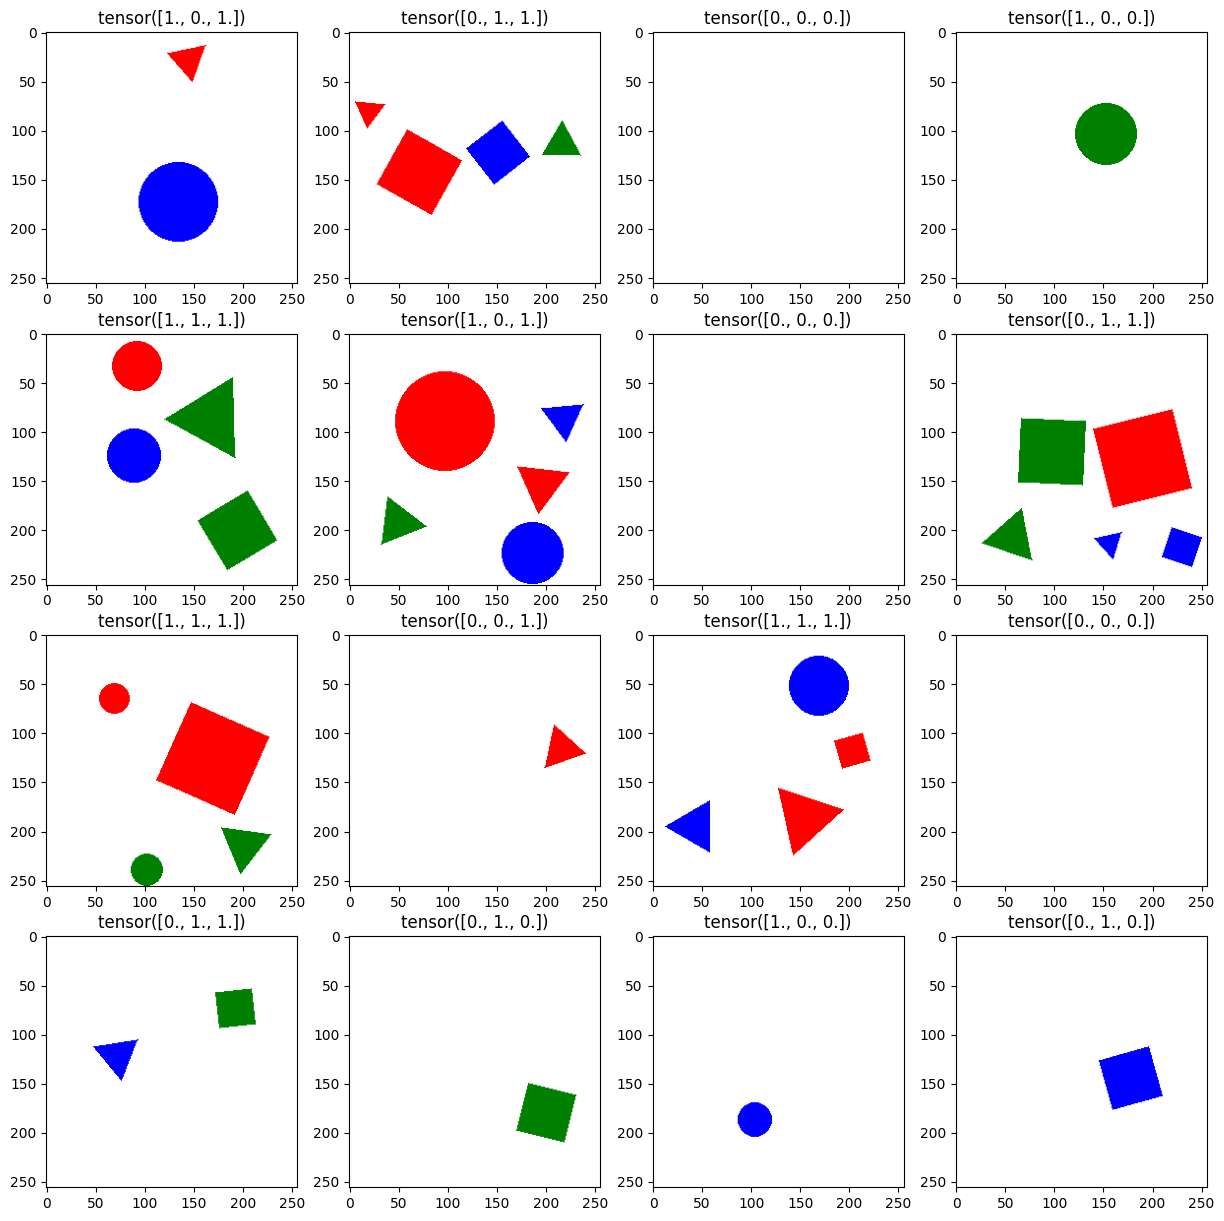

In [348]:
viz_batch = next(iter(train_loader))
fig, axs = plt.subplots(4,4,figsize = (15,15))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow((viz_batch[0][i*4+j, :, :].permute(1,2,0)),cmap='gray')
        axs[i,j].set_title(viz_batch[1][i*4+j])
        axs[i, j].axis('on')

Here, `transforms1` is just a basic transformation that converts to tensors. `transform2` takes in RGB images and outputs Canny edge detected binary thresholded outputs. Note that the batch size for both datasets is 64. This was explored when experimenting with training the networks. Batch sizes of 8 and 16 fail to give any improvements in training loss. Batch sizes of 32 do better but give unstable training i.e sharp jumps in loss. 64 was the optimal size.

## Model Architecture, loss function, output activations 

Model 1.
Let's try using a custom CNN model with three convolutional layers, batch normalization to speed up training, and four linear layers. Since we're predicting presence of shape, this is a binary classification problem and loss function is binary cross entropy loss `BCELoss`. This is because many shapes can be present at once without affecting the other's presence. Hence we don't use CrossEntropyLoss. This is also validated by our training labels not being one-hot vectors. When we use the model for regression, we will use `MSELoss`. Activations should be ReLU as binary class output can't be negative and neither can shape count. For output layer, we can use a 3 headed fully connected layer, each head corresponding to each shape's count. Optimizer is Adam with learning rate = 1e-3. Since this model is complex for the task we are aiming to perform, I've included dropout layers after each convolution to (hopefully) prevent overfitting.


In [349]:
criterion = nn.BCEWithLogitsLoss()
criterion2 = nn.MSELoss()
class Net3(nn.Module):
  def __init__(self):
    super(Net3,self).__init__()
    self.conv1 = nn.Conv2d(3,6,3,padding='same') #256x256
    self.pool = nn.MaxPool2d(2,2) #128x128
    self.bn1 = nn.BatchNorm2d(6)
    self.conv2 = nn.Conv2d(6,10,5,padding='same')
    self.bn2 = nn.BatchNorm2d(10)
    self.conv3 = nn.Conv2d(10,14,3,padding='same')
    self.bn3 = nn.BatchNorm2d(14)
    self.drop1 = nn.Dropout(p=0.6)
      
    self.fc1 = nn.Linear(14*32*32,500)
    self.fc2 = nn.Linear(500,100)
    self.fc3 = nn.Linear(100,20) 
    self.fc4 = nn.Linear(20,3) #Three headed network

  def forward(self,x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))

    x =  torch.flatten(x,1)

    x = F.relu(self.fc1(x))
    x = self.drop1(x)
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
      
    x = self.fc4(x) 
    return x

In [351]:
def train_model(model: torch.nn.Module, criterion: torch.optim, train_dl: torch.utils.data.DataLoader, val_dl: torch.utils.data.DataLoader, optimizer: torch.optim, n_epochs: int):
    if next(model.parameters()).is_cuda == False:
        model.to(device)

    train_history, val_history = [], []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        start = time.time()

        # Train Phase
        model.train()
        epoch_loss, n_batches = 0, 0
        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            n_batches += 1

        train_loss = epoch_loss / n_batches if n_batches > 0 else float("inf")
        train_history.append(train_loss)

        # Validation Phase
        model.eval()
        epoch_loss, n_batches = 0, 0
        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()
                n_batches += 1

        val_loss = epoch_loss / n_batches if n_batches > 0 else float("inf")
        val_history.append(val_loss)

        end = time.time()
        print(f'Epoch {epoch + 1}   Train_loss: {train_loss:.3f}   Val_loss: {val_loss:.3f}   Time: {end-start:.2f}s')

    print('Finished Training')
    return train_history, val_history

In [355]:
#Training for classification
net = Net3()
optimizer = optim.Adam(net.parameters(),lr = 1e-3)
train_his, val_his = train_model(net,criterion,train_loader,val_loader,optimizer,n_epochs=20)

Epoch 1   Train_loss: 0.535   Val_loss: 0.649   Time: 8.20s
Epoch 2   Train_loss: 0.436   Val_loss: 0.458   Time: 7.98s
Epoch 3   Train_loss: 0.415   Val_loss: 0.422   Time: 8.22s
Epoch 4   Train_loss: 0.402   Val_loss: 0.459   Time: 8.08s
Epoch 5   Train_loss: 0.384   Val_loss: 0.437   Time: 8.38s
Epoch 6   Train_loss: 0.364   Val_loss: 1.012   Time: 8.23s
Epoch 7   Train_loss: 0.337   Val_loss: 0.485   Time: 8.61s
Epoch 8   Train_loss: 0.299   Val_loss: 0.463   Time: 7.58s
Epoch 9   Train_loss: 0.261   Val_loss: 0.535   Time: 7.60s
Epoch 10   Train_loss: 0.214   Val_loss: 3.429   Time: 7.54s
Epoch 11   Train_loss: 0.174   Val_loss: 0.780   Time: 7.64s
Epoch 12   Train_loss: 0.139   Val_loss: 2.207   Time: 7.84s
Epoch 13   Train_loss: 0.128   Val_loss: 2.344   Time: 7.81s
Epoch 14   Train_loss: 0.092   Val_loss: 0.757   Time: 8.17s
Epoch 15   Train_loss: 0.085   Val_loss: 0.752   Time: 7.75s
Epoch 16   Train_loss: 0.078   Val_loss: 1.322   Time: 7.57s
Epoch 17   Train_loss: 0.073   Va

In [356]:
#Redefining datasets to run for regression
train_data = RegData(csv_data = 'train.csv',transform=transform1) #This dataset is for CLASSIFICATION
train_size = int(0.75*len(train_data))
val_size = len(train_data) - train_size
trainset, valset = random_split(train_data,[train_size,val_size])
train_loader = DataLoader(trainset,batch_size=64,shuffle=True)
val_loader = DataLoader(valset,batch_size=64,shuffle=True)

In [357]:
net2 = Net3()
optimizer_net2 = optim.Adam(net2.parameters(),lr=1e-3)
train_his_net2, val_his_net2 = train_model(net2,criterion2,train_loader,val_loader,optimizer_net2,n_epochs=20)

Epoch 1   Train_loss: 0.562   Val_loss: 0.533   Time: 7.36s
Epoch 2   Train_loss: 0.427   Val_loss: 0.446   Time: 7.30s
Epoch 3   Train_loss: 0.420   Val_loss: 0.426   Time: 7.37s
Epoch 4   Train_loss: 0.412   Val_loss: 0.391   Time: 7.53s
Epoch 5   Train_loss: 0.398   Val_loss: 0.462   Time: 7.47s
Epoch 6   Train_loss: 0.381   Val_loss: 0.414   Time: 7.48s
Epoch 7   Train_loss: 0.365   Val_loss: 0.645   Time: 7.34s
Epoch 8   Train_loss: 0.348   Val_loss: 0.530   Time: 7.35s
Epoch 9   Train_loss: 0.329   Val_loss: 0.433   Time: 7.42s
Epoch 10   Train_loss: 0.305   Val_loss: 0.570   Time: 7.55s
Epoch 11   Train_loss: 0.289   Val_loss: 0.526   Time: 7.51s
Epoch 12   Train_loss: 0.265   Val_loss: 0.639   Time: 7.47s
Epoch 13   Train_loss: 0.247   Val_loss: 0.589   Time: 7.77s
Epoch 14   Train_loss: 0.230   Val_loss: 0.575   Time: 7.54s
Epoch 15   Train_loss: 0.204   Val_loss: 0.657   Time: 7.56s
Epoch 16   Train_loss: 0.191   Val_loss: 0.567   Time: 7.62s
Epoch 17   Train_loss: 0.176   Va

#### Initial model training observation
The following observations were made from this model:
For classification:
1. The model begins to overfit from epoch 5 itself. However, training loss drops consistently to ~0.07 at the end of training. This indicates that the model is getting valid learning, but can't generalise.
2. Using learning rate schedulers and AdamW slowed down overfitting, but it could never generalise to a validation loss of less than ~0.45. This indicates that the model and data is adequate but not well fit for the task. 

For regression:
1. Initially, when trained without dropout layers and with a learning rate of 1e-3, the training loss after 15 epochs converges to ~0.002. However, the model badly overfits. The validation loss decreases to about 0.485 and increases severely by the 5th epoch to almost 1.4 by the end of training.
2. With dropout layers, the model doesn't overfit quite as much, but training loss also decreases slowly in comparison to case 1. The model does begin to overfit after the 5th epoch.
3. Using AdamW does not help much. The model overfits just like in case 1, however, the training proceeds slower.
4. A deeper CNN and more epochs just bring training loss down faster and overfit much earlier.

This indicates that we must use a simpler approach. If we want to continue the model-based approach, it is better to use a simpler model. This is so that we can prevent overfitting. Also, since using all of the regularization techniques didn't help in better learning, it is best to change architecture and hence the loss landscape. We can reduce complexity by reducing number of layers and subsequently, the number of parameters.

These results were obtained for both regression and classification in general. 
1. Since classification doesn't seem any 'easier' for the model to perform in general as seen from this training, it is better to focus on _regression_ which can learn more context about variously scaled shapes, since it has to recognise each shape in ground truth image, leading to more robustness.
2. Scaling and orientation of shapes is probably the main challenge to generalization and the reason for validation loss to not drop. To increase generalization capacity, let's introduce augmentations as `90 degree RandomRotations` as regularizers. Scaling augmentation is not performed as we don't want to crop out any shape in the image.

#### Simpler Model
A simpler architecture used below, with less conv2d layers but similar fully-connected layers. Dropout has been added between the fully connected layers. Let's see if it does any better at regression using original data.

In [360]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet,self).__init__()
        self.conv1 = nn.Conv2d(1,3,3,padding='same')
        self.conv2 = nn.Conv2d(3,5,3,padding='same')
        self.pool = nn.MaxPool2d(2,2)
        self.bn1 = nn.BatchNorm2d(3)
        self.bn2 = nn.BatchNorm2d(5)
        self.drop1 = nn.Dropout(p=0.4)
          
        self.fc1 = nn.Linear(5*64*64,100)
        self.fc2 = nn.Linear(100,50)
        self.fc3 = nn.Linear(50,3)
    def forward(self,x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x =  torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [361]:
simple_net = SimpleNet()
optimizer2 = optim.Adam(simple_net.parameters(),lr=1e-3)
train_his2, val_his2 = train_model(simple_net,criterion2,train_loader2,val_loader2,optimizer2,n_epochs=20)

Epoch 1   Train_loss: 0.559   Val_loss: 0.448   Time: 8.01s
Epoch 2   Train_loss: 0.441   Val_loss: 0.473   Time: 8.11s
Epoch 3   Train_loss: 0.410   Val_loss: 0.463   Time: 8.19s
Epoch 4   Train_loss: 0.380   Val_loss: 0.556   Time: 7.97s
Epoch 5   Train_loss: 0.356   Val_loss: 0.512   Time: 8.17s
Epoch 6   Train_loss: 0.323   Val_loss: 0.595   Time: 7.90s
Epoch 7   Train_loss: 0.292   Val_loss: 0.588   Time: 8.31s
Epoch 8   Train_loss: 0.269   Val_loss: 0.561   Time: 7.97s
Epoch 9   Train_loss: 0.243   Val_loss: 0.562   Time: 8.33s
Epoch 10   Train_loss: 0.211   Val_loss: 0.582   Time: 7.86s
Epoch 11   Train_loss: 0.202   Val_loss: 0.586   Time: 7.86s
Epoch 12   Train_loss: 0.190   Val_loss: 0.579   Time: 8.18s
Epoch 13   Train_loss: 0.185   Val_loss: 0.557   Time: 8.00s
Epoch 14   Train_loss: 0.172   Val_loss: 0.572   Time: 8.15s
Epoch 15   Train_loss: 0.161   Val_loss: 0.567   Time: 8.63s
Epoch 16   Train_loss: 0.149   Val_loss: 0.577   Time: 8.20s
Epoch 17   Train_loss: 0.154   Va

A smaller and lighter architecture tends not to overfit. However, since the architecture is not very deep, the training loss does not decrease much. As can be seen, the model slightly overfits towards the middle of training. However, training loss decreases consistently. This shows that the model is starting to memorise the data. However, the training loss is much better than the previous model and so is the overfitting. To prevent overfitting further, we introduce augmentations. 

Another observation is that, when playing around with the architecture, adding fully connected layers increases overfitting. Adding convolutional layers seems to reduce loss more extensively. This is probably because our model should learn spatial structure from training images and not correlation patterns. In the next architecture, we use more convolutional layers and minimal fully connected layers with just augmentations as regularization.

In [362]:
transform3 = transforms.Compose([
    transforms.Lambda(lambda x: cv2.cvtColor(np.array(x), cv2.COLOR_RGB2BGR)),
    transforms.Lambda(lambda x: cv2.Canny(x, 5, 70)), 
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).unsqueeze(0)),
    transforms.RandomRotation(90),
])

In [367]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet,self).__init__()
        self.conv1 = nn.Conv2d(1,3,3,padding='same')
        self.conv2 = nn.Conv2d(3,5,3,padding='same')
        self.conv3 = nn.Conv2d(5,8,3,padding='same')
        self.conv4 = nn.Conv2d(8,10,3,padding='same')
        self.pool = nn.MaxPool2d(2,2)
        self.bn1 = nn.BatchNorm2d(3)
        self.bn2 = nn.BatchNorm2d(5)
        self.bn3 = nn.BatchNorm2d(8)
        self.bn4 = nn.BatchNorm2d(10)
        self.drop1 = nn.Dropout(p=0.4)
          
        self.fc1 = nn.Linear(10*16*16,50)
        self.fc2 = nn.Linear(50,3)
    def forward(self,x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x =  torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [368]:
train_data3 = RegData(csv_data = 'train.csv',transform=transform3)
train_size = int(0.75*len(train_data3))
val_size = len(train_data3) - train_size
trainset, valset = random_split(train_data3,[train_size,val_size])
train_loader3 = DataLoader(trainset,batch_size=32,shuffle=True)
val_loader3 = DataLoader(valset,batch_size=32,shuffle=True)
simple_net2 = SimpleNet()
optimizer3 = optim.Adam(simple_net2.parameters(),lr=1e-3)

In [369]:
train_his3, val_his3 = train_model(simple_net2,criterion2,train_loader3,val_loader3,optimizer3,n_epochs=63) #Initially, 47

Epoch 1   Train_loss: 0.456   Val_loss: 0.427   Time: 12.10s
Epoch 2   Train_loss: 0.421   Val_loss: 0.459   Time: 12.50s
Epoch 3   Train_loss: 0.413   Val_loss: 0.406   Time: 12.29s
Epoch 4   Train_loss: 0.405   Val_loss: 0.442   Time: 12.42s
Epoch 5   Train_loss: 0.398   Val_loss: 0.419   Time: 12.46s
Epoch 6   Train_loss: 0.387   Val_loss: 0.388   Time: 12.03s
Epoch 7   Train_loss: 0.375   Val_loss: 0.414   Time: 12.26s
Epoch 8   Train_loss: 0.370   Val_loss: 0.359   Time: 12.32s
Epoch 9   Train_loss: 0.335   Val_loss: 0.319   Time: 12.85s
Epoch 10   Train_loss: 0.313   Val_loss: 0.357   Time: 13.15s
Epoch 11   Train_loss: 0.290   Val_loss: 0.424   Time: 12.45s
Epoch 12   Train_loss: 0.279   Val_loss: 0.276   Time: 11.94s
Epoch 13   Train_loss: 0.270   Val_loss: 0.325   Time: 13.72s
Epoch 14   Train_loss: 0.258   Val_loss: 0.249   Time: 13.65s
Epoch 15   Train_loss: 0.263   Val_loss: 0.291   Time: 15.14s
Epoch 16   Train_loss: 0.256   Val_loss: 0.269   Time: 13.57s
Epoch 17   Train_

The model gets a good training as well as validation loss! We can observe how both decrease significantly and consistently. Validation is a bit jagged, however training for ~60 epochs was shown to reduce these values to their apparent minimum. So augmentations are an effective regularizer.

Let's plot the training and test losses to see how the losses are changing with epochs.

In [373]:
def figure(epochs,train,val,lr):

  epoch_range = range(1,epochs+1)
  log_train = np.log(train)
  log_val = np.log(val)

  plt.figure()
  plt.plot(epoch_range,log_train,label = 'Training Loss')
  plt.plot(epoch_range,log_val,label = 'Validation Loss')

  plt.xlabel("Epochs")
  plt.ylabel('Log(loss)')
  plt.legend()
  plt.title(f'SimpleNet - Learning Rate: {lr}')
  plt.show()

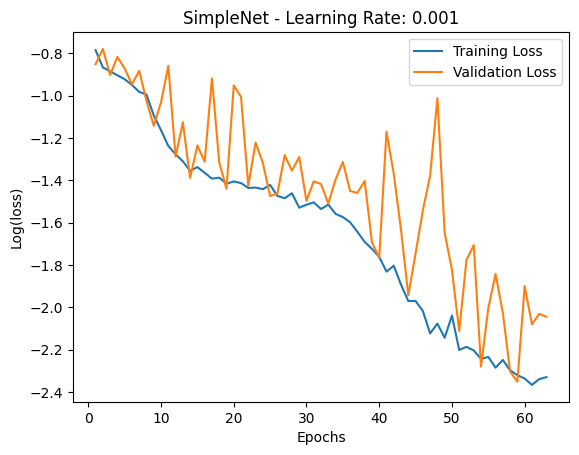

In [374]:
figure(63,train_his3,val_his3,lr=1e-3)

## Custom metrics and evaluation

Let's try to evaluate if the respective models put us in a good position to make predictions about colours of shapes. To do this, I'll first test the model outputs on colour images. This is because the model has been trained on a input image set which was normalised and binary. Before feeding colour images, let's see if the domain shift between these input sets has a great impact on output.

A few ad-hoc evaluation metrics can be used for our purpose. Since the losses have reached a good value and I don't have any testing data, one metric is looking at a 'confusion matrix' to see if any specific shapes are consistently being recognised wrong/inadequately. If so, we'd need to increase model complexity slightly or make validation smoother. Basically I want to test if the model can recognise shapes effectively enough already or not. So the confusion matrix is based on output labels vs true labels.


#### Evaluation

In [28]:
def eval_model(model: nn.Module, batch: DataLoader):
    with torch.no_grad():
        #for images,_ in dataloader: #We want to focus on our model inputs
        images = batch[0]
        images = images.to(device)
        model = model.to(device)
        outputs = model(images)
        outputs = torch.round(outputs) #Thresholding
    return outputs

First, let's try to run a forward pass through the model to determine the types of inferences the model seems to be making. If the predictions on a random set of images from dataset are good, we can try to classify the colours of each shape by _mapping from color images to grayscale space_.

In [404]:
sample_batch = next(iter(train_loader3))
outputs1 = eval_model(simple_net2,sample_batch)

In [412]:
shps = train_data3.classes

/home/ojas/miniconda3/envs/cv2024/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


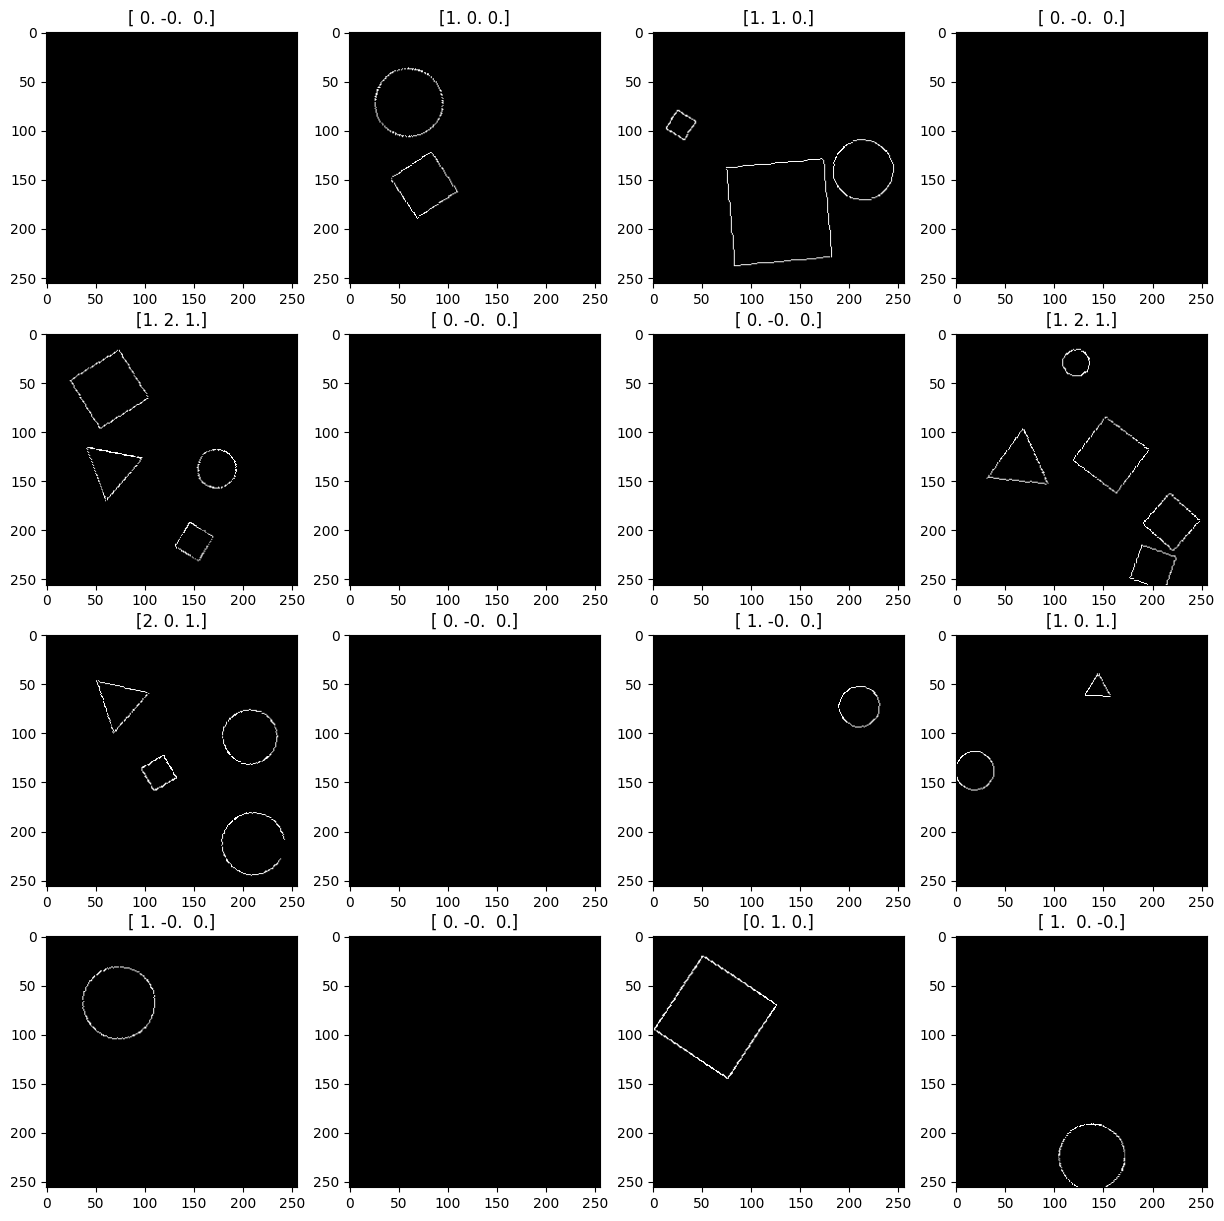

In [31]:
fig, axs = plt.subplots(4,4,figsize = (15,15))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow((sample_batch[0][i*4+j, :, :].permute(1,2,0)),cmap='gray')
        axs[i,j].set_title(outputs1[i*4+j].cpu().numpy())
        axs[i, j].axis('on')

The outputs are fairly good.

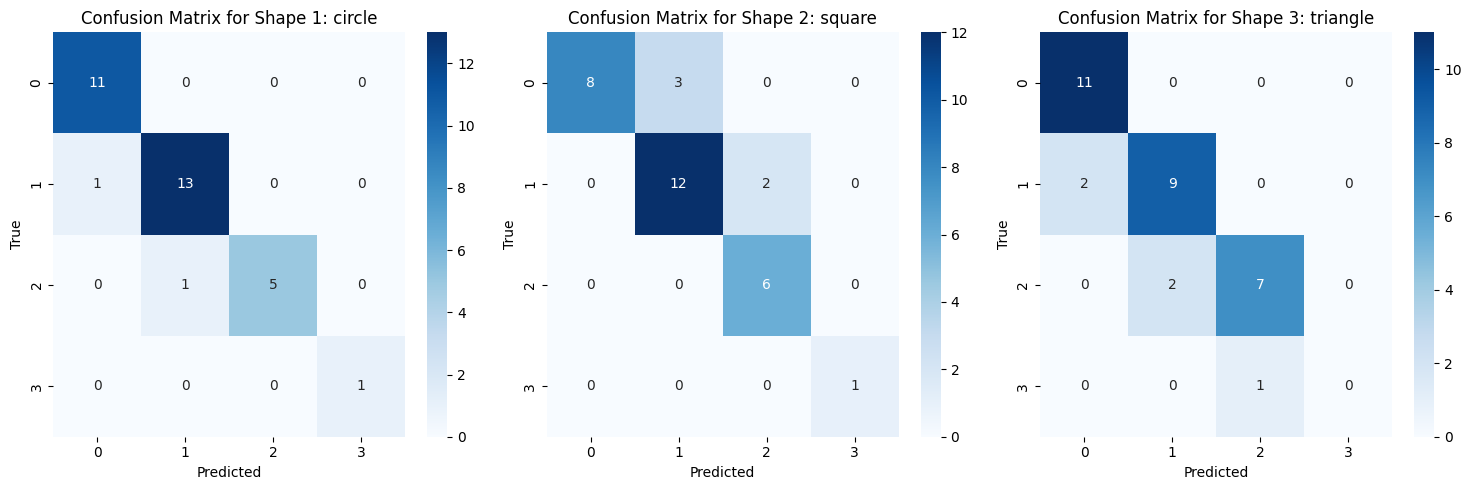

In [415]:
# Convert tensors to numpy arrays for easier manipulation
labels_batch_np = np.array(sample_batch[1])
outputs1_np = outputs1.cpu().numpy()

gt_shape1 = labels_batch_np[:, 0]
gt_shape2 = labels_batch_np[:, 1]
gt_shape3 = labels_batch_np[:, 2]

pred_shape1 = outputs1_np[:, 0]
pred_shape2 = outputs1_np[:, 1]
pred_shape3 = outputs1_np[:, 2]

cm_shape1 = confusion_matrix(gt_shape1, pred_shape1)
cm_shape2 = confusion_matrix(gt_shape2, pred_shape2)
cm_shape3 = confusion_matrix(gt_shape3, pred_shape3)

# Plot confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_shape1, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title(f'Confusion Matrix for Shape 1: {shps[0]}')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_shape2, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title(f'Confusion Matrix for Shape 2: {shps[1]}')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

sns.heatmap(cm_shape3, annot=True, fmt="d", cmap="Blues", ax=axs[2])
axs[2].set_title(f'Confusion Matrix for Shape 3: {shps[2]}')
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('True')

plt.tight_layout()
plt.show()

As can be seen, predictions are pretty good on a sample batch. There are some instances of confusion between 1 or 2 counts, or 0 or 1 counts. These must be the cases where there are many shapes in the image and the model mis-counts a small shape or so. However, the model looks fairly good and we can proceed without major concerns.

### Further approach
We use the current base shape recognition model (ShapeNet) for shape classification. We will pre-train this model on the training data, preprocessed as described above. `simple_net2` contains this pretrained model. In the next step, we'll _freeze_ this model and use it just for inference. We'll use grayscaled versions of the same input images to learn the mapping from discrete values in RGB space to the specific mapping in grayscale space. The main working idea is that the model, which has learnt what various shapes look like, learns to count shapes in Canny edge detected space. As shown ahead, RGB values in input dataset are converted to a specific number in grayscale. If we feed in to the model this specific image plane which contains shapes only of a specific color, we can directly count the shapes in each image to get the tuple count.
This is again modeled as a regression problem. First, we need to understand this mapping and filter shapes by colour to grayscale/Canny.

## Preparing for colour recognition

#### Showing that grayscale maps to specific outputs

Generally when converting from RGB to grayscale, the formula used is:  0.299 ∙ Red + 0.587 ∙ Green + 0.114 ∙ Blue.
Hence, specific values in RGB, which denote the respective shapes in RGB space, are mapped to a specific value in grayscale space. We'll try to find this mapping.

In [397]:
#Testing if grayscaling works
transform_gray = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])

[0.29411766 0.29803923 1.        ]


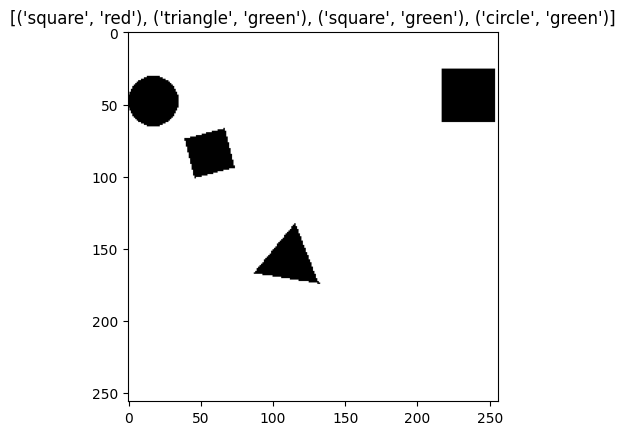

In [376]:
gray_set = ImageDataset(csv_data = 'train.csv',transform=transform_gray)
gray_loader = DataLoader(gray_set,batch_size=16)
viz_gray = next(iter(gray_loader))
ref_img = viz_gray[0][11] #Randomnly chosen
plt.imshow(ref_img.permute(1,2,0),cmap='gray')
plt.title(viz_gray[1][11])
ref_np = ref_img.numpy()
print(np.unique(ref_np))

#Note that the difference between two of these is very slight

#### Training for colour recognition

This dataset is not used for training, but just as visualisation of how the colors look in grayscale space.

In [377]:
class TrainColor(Dataset):
        def __init__(self,csv_data,transform):
            self.data = pd.read_csv(csv_data)
            self.transforms = transform
            self.colors = list(set(color for sublist in self.data['label'] for (_,color) in ast.literal_eval(sublist))) #Find unique colors in label of dataFrame
        
        def __len__(self):
            return len(self.data)
    
        def __getitem__(self,idx):
            img_path = 'dataset/' + self.data.iloc[idx,0]
            label = self.data.iloc[idx,1]
            shapes = ast.literal_eval(label)
            shapes = ast.literal_eval(label) #Converts string to list
            color_counts = Counter(color for shape, color in shapes) #Counts only shapes in label

            label_tensor = torch.tensor([color_counts.get(color,0) for color in self.colors], dtype = torch.float32)
            for i in range(len(label_tensor)): #Momentarily converting to classification problem
                if label_tensor[i] > 0:
                    label_tensor[i] = 1
                else: 
                    continue
            image = Image.open(img_path)
            image = self.transforms(image)
            return image, label_tensor

In [378]:
train_color = TrainColor(csv_data = 'train.csv',transform=transform_gray)
train_size = int(0.75*len(train_color))
val_size = len(train_color) - train_size
trainset, valset = random_split(train_color,[train_size,val_size])
color_train_loader = DataLoader(trainset,batch_size=32,shuffle=True)
color_val_loader = DataLoader(valset,batch_size=32,shuffle=True)

In [379]:
train_color.colors

['green', 'blue', 'red']

In [380]:
viz_batch = next(iter(color_train_loader))

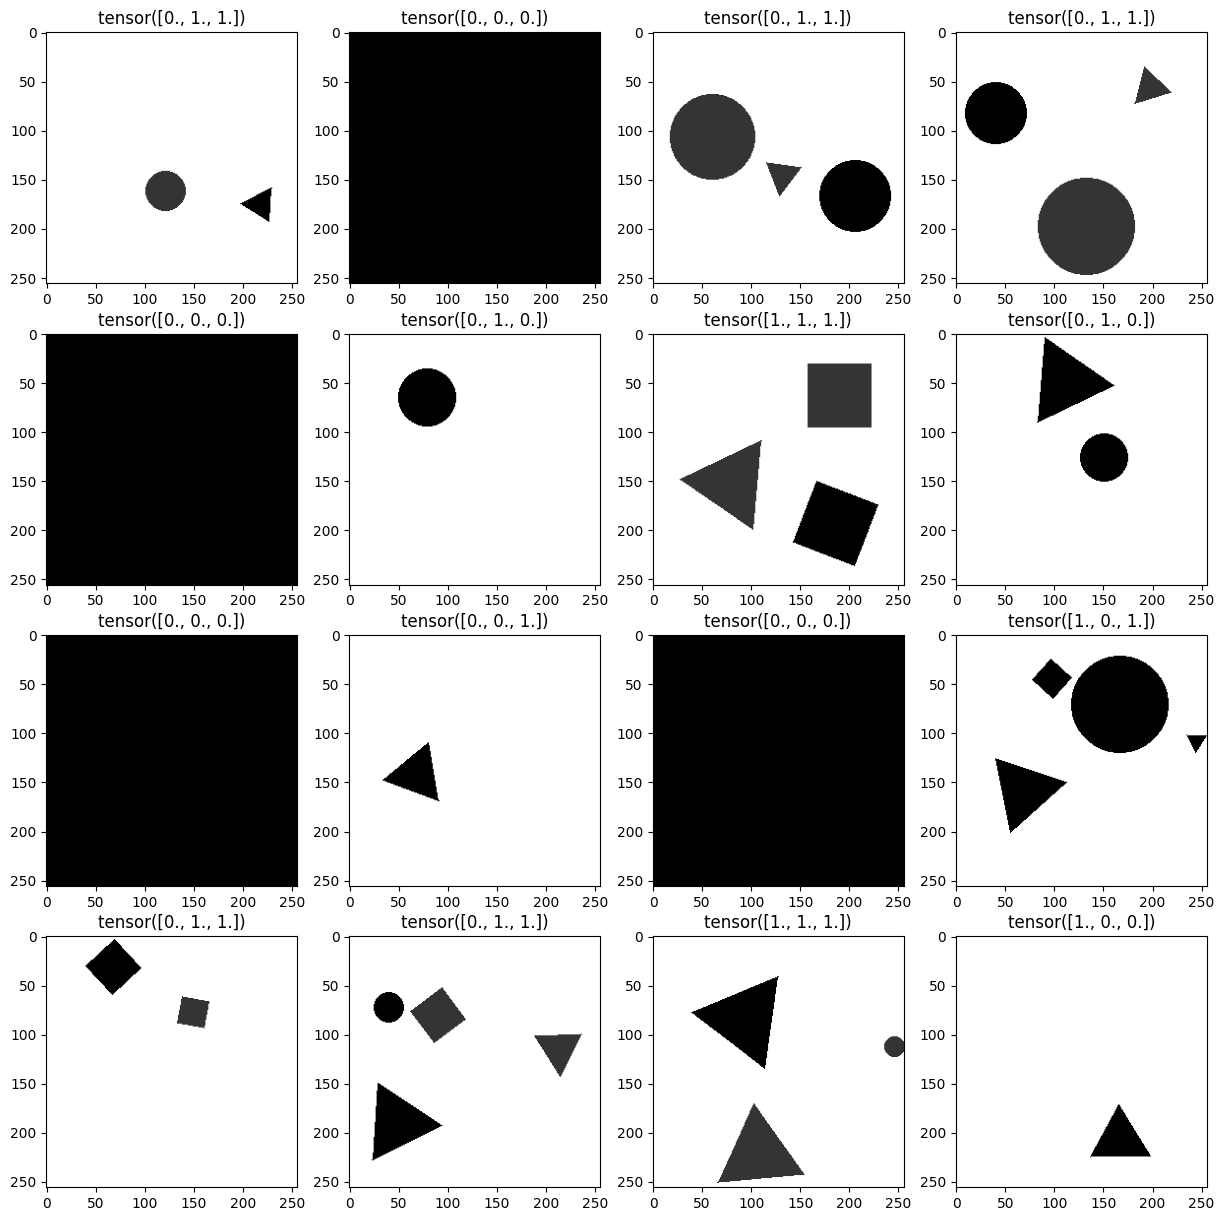

In [381]:
fig, axs = plt.subplots(4,4,figsize = (15,15))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow((viz_batch[0][i*4+j, :].permute(1,2,0)),cmap='gray')
        axs[i, j].set_title(viz_batch[1][i*4+j])
        axs[i, j].axis('on')

Let's try to model exactly which colour is mapped to which unique value in the grayscaled version of the image.

### Color model
This model is to determine which colour maps to which unique intensity value in the grayscale image. After this, we can segment out the regions with particular colours, directly filter the images via Canny and finally run the `shape_net` to determine (shape,color) pair.

torch.Size([1, 256, 256])


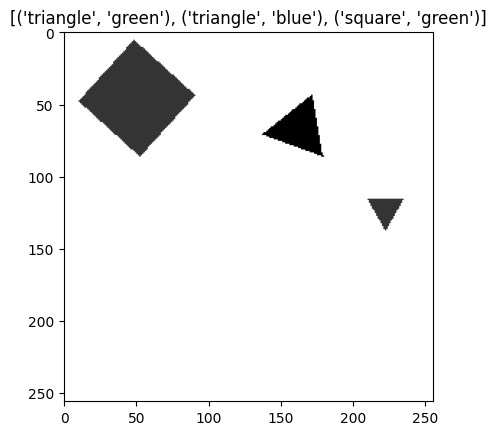

In [387]:
# For visualisation
viz_gray = next(iter(gray_loader))
ref_img = viz_gray[0][5].cpu() #Randomnly chosen
plt.imshow(ref_img.permute(1,2,0),cmap='gray')
plt.title(viz_gray[1][5])
ref_np = ref_img.numpy()
print(ref_img.shape)

We can see via this empirical testing (by comparing ground truth labels with unique values) that the colour mappings are as follows:
1. blue = 0.11372549
2. green = 0.29411766
3. red = 0.29803923

Now, we can use this to filter out shapes by color. Applying shape inference, we can find the desired pairs of (shape,color)

#### Testing filtering and shape inference

In [388]:
ref_red = 0.29803923
ref_green = 0.29411766
ref_blue = 0.11372549

In [389]:
def filterColor(color,image):
    img = image.permute(1,2,0).numpy() #Bring tensor to format, convert to numpy and arrange in numpy format #256x256x1
    filtered_image = 255*(img == color) * img #255*val for color shapes, 0 otherwise
    return torch.from_numpy(filtered_image) #256x256x1

Text(0.5, 1.0, 'Red Object')

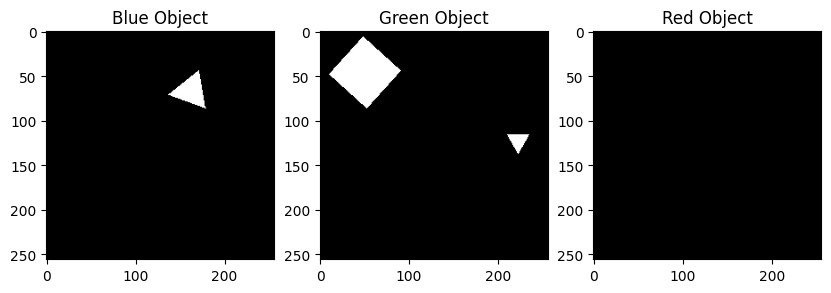

In [390]:
blue_ref_img = filterColor(ref_blue,ref_img)
red_ref_img = filterColor(ref_red,ref_img)
green_ref_img = filterColor(ref_green,ref_img)
fig,axs = plt.subplots(1,3,figsize = (10,10))

axs[0].imshow(blue_ref_img,cmap='gray')
axs[0].set_title("Blue Object")
axs[1].imshow(green_ref_img,cmap='gray')
axs[1].set_title("Green Object")
axs[2].imshow(red_ref_img,cmap='gray')
axs[2].set_title("Red Object")

Hence filtering logic works.

## Final output model

This is the final model through which we will make colour and shape predictions. This model takes in the grayscale images as input. Hence, we initially use a transform on the color images obtained from the test dataset folder. Firstly, we used the color model and the `filterColor` function to separate into red, green and blue object labelled images. Next, we transform it just like the transforms used for training `shapeNet` and determine counts of respective objects in each image. Then using a vector to text conversion, we convert into final output label. Each forward pass will return one label.

In [391]:
def eval_model_forward(model: nn.Module, batch: DataLoader):
    with torch.no_grad():
        #for images,_ in dataloader: #We want to focus on our model inputs
        images = batch
        outputs = model(images)
        outputs = torch.round(outputs) #Thresholding
    return outputs

In [392]:
#Check order of shapes in tensor
order = train_data2.classes
print(order)

['circle', 'square', 'triangle']


In [393]:
transform_canny = transforms.Compose([
    transforms.Lambda(lambda x: np.array(x).astype(np.uint8)), 
    transforms.Lambda(lambda x: cv2.Canny(x, 5, 60)),  # Apply Canny edge detection
    transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
    transforms.Lambda(lambda x: x.unsqueeze(0).unsqueeze(0)),  # Reshape to [1,1,H,W]
])

In [394]:
#Function to convert vectors to output labels
#Returns a list
def arrange_labels(shape_order,shape_output,color):
    output = []
    shape_output = shape_output.numpy()
    output = [(shape,color) for i, shape in enumerate(shape_order) if shape_output[0][i] > 0]
    return output

In [416]:
class FinalNet(nn.Module):
    def __init__(self,shape_net,filter_color,ref_red,ref_green,ref_blue,arrange_labels):
        super(FinalNet,self).__init__()
        self.shape_net = shape_net
        for param in self.shape_net.parameters():
            param.requires_grad = False
        self.filter_color = filter_color
        self.red = ref_red
        self.green = ref_green
        self.blue = ref_blue
        self.labels = arrange_labels
        self.order = order #Order of shapes
        self.final = []

    def forward(self,x):
        #First separate into r,g,b
        self.final = []
        self.shape_net.cpu()
        r = self.filter_color(self.red,x) #1x256x256
        g = self.filter_color(self.green,x)
        b = self.filter_color(self.blue,x)
        
        r_canny = transform_canny(r)
        g_canny = transform_canny(g)
        b_canny = transform_canny(b)
        
        output_r = eval_model_forward(self.shape_net,r_canny)
        output_g = eval_model_forward(self.shape_net,g_canny)
        output_b = eval_model_forward(self.shape_net,b_canny)
        
        red = self.labels(self.order,output_r,'red')
        green = self.labels(self.order,output_g,'green')
        blue = self.labels(self.order,output_b,'blue')

        self.final = (red + green + blue)
        return str(self.final)

Let's test an example output. Let's use `ref_img` from the beginning of this section.

In [419]:
finalNet = FinalNet(simple_net2,filterColor,ref_red,ref_green,ref_blue,arrange_labels)
output = finalNet(ref_img)
print(output)

[('square', 'green'), ('triangle', 'green'), ('triangle', 'blue')]


Hence, the model is able to accurately predict the color and shape pairs. 

### Evaluation

Hence, we learn and pre-train a model to recognise various shapes in the input images. We then learn a mapping from the RGB intensities of these to specific grayscale values. Using this, we filter out the images by colour, thereby assigning labels for color in (shape,color) pair. Using the pretrained model, we determine the shapes. _We don't output multiple labels of same (shape,color)_ pair as per guidelines. As we evaluated the pre-trained model earlier and the mapping for color is deterministic, we don't do any additional evaluations here. Also since there is no testing data, any evaluation here might be biased, so we judge by model quality.

### Comments and discussion of advantages & weaknesses

The advantages of model are that the pre-training is lightweight as model is not very complex. It also has quick inference through the entire pipeline. It can also generalize to several shapes, as the `RegData` class scans for all unique shapes in input labels. Hence, no aspect of the shapes is hard-coded. 

One drawback may be that fixed color presence with no overlap/color mixing is a very easy case. Since the colors we mutually independent for each shape, we could easily filter out by color. However, in the case where we have multiple shading, the colour tags would get confused, although shape prediction would proceed unaffected due to pre-processing.

Thank you!

## Submission Files

In [420]:
test_data = pd.read_csv('test.csv')

In [421]:
test_data['label'] = ""
test_data

,image_path,label
0,test_dataset/img_0.png,
1,test_dataset/img_1.png,
2,test_dataset/img_2.png,
3,test_dataset/img_3.png,
4,test_dataset/img_4.png,
...,...,...
995,test_dataset/img_995.png,
996,test_dataset/img_996.png,
997,test_dataset/img_997.png,
998,test_dataset/img_998.png,


In [422]:
submission_ojas = pd.DataFrame()
submission_ojas['image_path'] = ""
submission_ojas['label'] = ""

In [423]:
data = []
for path in test_data['image_path']:
    #Take the path and get the image, convert to grayscale and run through the pipeline.
    img_path = 'dataset/' + path
    image = Image.open(img_path)
    image = transform_gray(image)
    label = finalNet(image)
    data.append({"image_path": path, "label": label})  # Store data

In [424]:
submission_ojas = pd.DataFrame(data)
submission_ojas.to_csv("submission_ojas.csv", index=False)